## Goal: We want to know to what extent highly-divergent variant positions in non-European populations are responsible for the appearance of novel exons
We'll limit this analyses to the contrasts that have CEU in them, because we know that the annotation is European-biased, and therefore the novelty of exons is dependent on this bias

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot
import math


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = pd.read_csv(proc_cfg(config['lr']['exons_ss_in_pops_fsts_summary'], od),
                 sep='\t')
df.rename({'pop2_der':'pop2_det'}, 
          axis=1, inplace=True)

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

2943235
1719222


,eid,novelty,pop1_det,pop2_det,Chromosome,Strand,Start,End,pop1,pop2,End_b,fst,Start_b
197,chr1_+_100007033_100007156,Known,True,True,chr1,+,100007031,100007158,HAC,YRI,100007048,0.393014,100007047
198,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043099,0.041198,100043098
199,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043213,0.000000,100043212
200,chr1_+_100049908_100050004,Known,True,True,chr1,+,100049906,100050006,HAC,YRI,100049941,0.018298,100049940
201,chr1_+_100140407_100141019,Known,True,True,chr1,+,100140405,100141021,HAC,YRI,100140797,0.047965,100140796


In [5]:
# 1. limit to just contrasts that involve CEU
df = df.loc[(df.pop1=='CEU')|(df.pop2=='CEU')]

,eid,novelty,pop1_det,pop2_det,Chromosome,Strand,Start,End,pop1,pop2,End_b,fst,Start_b
771951,chr1_+_100007033_100007156,Known,True,True,chr1,+,100007031,100007158,HAC,CEU,100007048,0.043518,100007047
771952,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,CEU,100043099,0.018770,100043098
771953,chr1_+_100049908_100050004,Known,True,True,chr1,+,100049906,100050006,HAC,CEU,100049941,0.035394,100049940
771954,chr1_+_100049908_100050004,Known,True,True,chr1,+,100049906,100050006,HAC,CEU,100049981,0.000000,100049980
771955,chr1_+_100140407_100141019,Known,True,True,chr1,+,100140405,100141021,HAC,CEU,100140998,0.002820,100140997


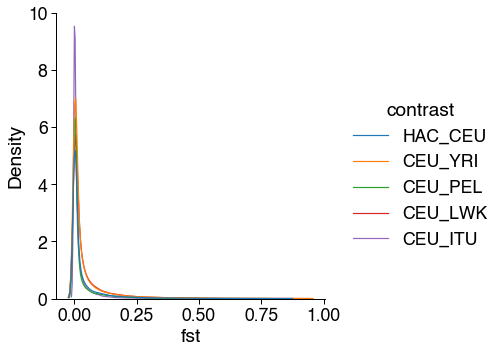

In [8]:
# plot distribution of Fsts
df['contrast'] = df.pop1+'_'+df.pop2
init_plot_settings()
ax = sns.displot(df, 
            x='fst',
            hue='contrast',
            kind='kde')      

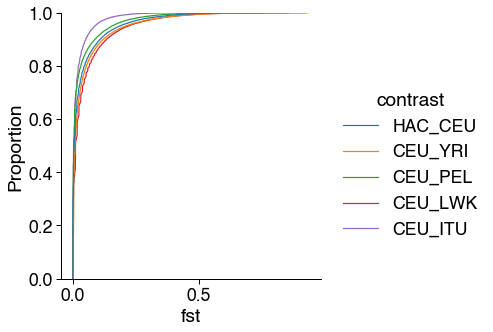

In [10]:
# plot distribution of Fsts
df['contrast'] = df.pop1+'_'+df.pop2
init_plot_settings()
ax = sns.displot(df, 
            x='fst',
            hue='contrast',
            kind='ecdf')      

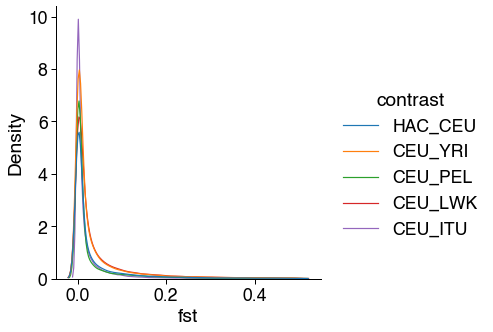

In [9]:
# plot distribution of Fsts
temp = df.loc[df.fst<0.5]
init_plot_settings()
ax = sns.displot(temp, 
            x='fst',
            hue='contrast',
            kind='kde')      

In [11]:
# 2. call variant positions as divergent or non-divergent
div_thresh = 0.2
df['divergent'] = df.fst>=div_thresh

In [73]:
# loop through each contrast
stat_df = pd.DataFrame()
for nov in ["Novel 5'/3'", 'Novel']:
    for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                          df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
        temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
        temp.rename({'pop1_det':pop1,
                 'pop2_det':pop2}, axis=1, inplace=True)
        
        # ensure we're always talking about uniq exon+variant pos pairs
        assert len(temp.index) == len(temp[['eid', 'End_b', 'Start_b']].drop_duplicates())

        # 3. compute contingency table and test
        # columns --> intersects novel exon; intersects any exon
        # rows --> highly divergent vs. not divergent

        non_ceu_pop = [p for p in [pop1, pop2] if p != 'CEU'][0]

        # testing variants
        # - intersecting novel exons ONLY detected in the non-CEU pop
        nov_uniq_df = temp.loc[(temp[non_ceu_pop]==True)&\
                               (temp['CEU']==False)&\
                               (temp.novelty==nov)]
        nov_uniq_df = nov_uniq_df[['divergent', 'eid']].groupby('divergent').count().rename({'eid':'n_var_exon_pairs'}, axis=1).reset_index()
        nov_uniq_col = f'{nov}, {non_ceu_pop}-unique'
        nov_uniq_df['label'] = nov_uniq_col

        # background varians
        # - intersecting known or novel exons which are detected in both
        bg_df = temp.loc[(temp[non_ceu_pop]==True)&\
                         (temp['CEU']==True)]
        bg_df = bg_df[['divergent', 'eid']].groupby('divergent').count().rename({'eid':'n_var_exon_pairs'}, axis=1).reset_index()
        bg_col = f'{non_ceu_pop}-CEU shared'
        bg_df['label'] = bg_col

        temp = pd.concat([nov_uniq_df, bg_df], axis=0)

        temp = temp.pivot(index='label',
                          values = 'n_var_exon_pairs',
                          columns = 'divergent')
        temp = temp.sort_index()
        print(temp)
        break
    break
#         temp = temp.values

#         # Perform Fisher's Exact Test
#         odds_ratio, p_value = st.fisher_exact(temp, alternative='greater')

#         print(f'{pop1} vs. {pop2}')
#         print(f'Hypoth: variant positions intersecting {nov} exons are enriched for being divergent')
#         print("Odds Ratio:", odds_ratio)
#         print("P-value:", p_value)
#         print()

divergent                False  True
label                               
HAC-CEU shared           60554  2700
Novel 5'/3', HAC-unique   1725    98


In [76]:
temp.index

Index(['HAC-CEU shared', 'Novel 5'/3', HAC-unique'], dtype='object', name='label')

In [66]:
# temp.loc[temp[['Start_b', 'End_b']].duplicated(keep=False)].sort_values(by=['Start_b', 'End_b']) # there are dupe. var. pos.

divergent                False  True
label                               
HAC-CEU shared           60554  2700
Novel 5'/3', HAC-unique   1725    98


HAC vs. CEU
Hypoth: variant positions intersecting Novel 5'/3' exons are enriched for being divergent
Odds Ratio: 1.2741367686527107
P-value: 0.014680523126554525

